In [1]:
#####Gaussian Process Spatio Temporal point model#####
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.matlib
import scipy.linalg
import itertools
import calendar
from datetime import datetime
from datetime import timedelta
from scipy import sparse
from scipy.stats import norm
from numpy.random import *
from scipy import optimize

In [2]:
##乱数を生成する関数を設定
#多項分布の乱数を生成する関数
def rmnom(pr, n, k, pattern):
    if pattern==1:
        z_id = np.array(np.argmax(np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis], axis=1), dtype="int")
        Z = np.diag(np.repeat(1, k))[z_id, ]
        return z_id, Z
    z_id = np.array(np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1), dtype="int")
    return z_id

#多変量正規分布の乱数を生成する関数
def rmvnorm(mu, Cov, hh, k):
    s = mu + np.random.normal(0, 1, hh*k).reshape(hh, k)
    P = np.linalg.cholesky(Cov)
    y = np.dot(P, s.T).T
    return y

#任意の相関行列を作る関数
def CorM(col, lower, upper, eigen_lower, eigen_upper, pattern):
    #相関行列の初期値を定義する
    if pattern==1:
        Prob = np.abs(lower) / (np.abs(lower) + np.abs(upper))
        z = np.random.binomial(1, Prob, col*col); z[z==0] = -1
        cov_vec = np.random.beta(1.0, 3.0, col*col) * z   #相関係数の乱数ベクトルを作成
    else:
        cov_vec = np.random.uniform(lower, upper, col*col)   #相関係数の乱数ベクトルを作成
    rho = np.tril(cov_vec.reshape(col, col), k=-1)   #乱数ベクトルを下三角行列化
    Sigma = (rho + rho.T) + np.diag(np.repeat(1, col))   #対角成分を1にする
    
    #相関行列を正定値行列に変更
    #固有値分解を実行
    eigen = np.linalg.eigh(Sigma)
    eigen_val = eigen[0] 
    eigen_vec = eigen[1]
    
    #固有値が負の数値を正にする
    for i in range(col):
        if eigen_val[i] < 0:
            eigen_val[i] = np.random.uniform(eigen_lower, eigen_upper, 1)
            
    #新しい相関行列の定義と対角成分を1にする
    Sigma = np.dot(np.dot(eigen_vec, np.diag(eigen_val)), eigen_vec.T)
    normalization_factor = np.dot(np.power(np.diag(Sigma), 0.5)[:, np.newaxis], np.power(np.diag(Sigma), 0.5)[np.newaxis, :])
    Cor = Sigma / normalization_factor
    return Cor

#相関行列から分散共分散行列に変換する関数
def covmatrix(Cor, sigma_lower, sigma_upper):
    sigma = (sigma_upper - sigma_lower) * rand(np.diag(Cor).shape[0]) + sigma_lower
    sigma_factor = np.dot(sigma[:, np.newaxis], sigma[np.newaxis, :])
    Cov = Cor * sigma_factor
    return Cov

#分散共分散行列から相関行列に変換する関数
def cov2cor(Cov):
    D = np.diag(np.power(np.diag(Cov), -1/2))
    corr = np.dot(np.dot(D, Cov), D)
    return corr

In [15]:
####データの生成####
##データの設定
weeks = 7
k = 10
place = 3000
category = 150
max_m = 5
m = np.random.poisson(1.5, place)
m[m==0] = 1; m[m > max_m] = max_m 
Lambda = np.random.gamma(75, 1/0.5, place)
pt = np.random.poisson(Lambda, place)
N = np.sum(pt)
m_vec = np.repeat(1.0, max_m)
k_vec = np.repeat(1.0, k)

In [16]:
##idとインデックスを作成
#idの作成
d_id = np.repeat(np.arange(place), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(place)])))

#インデックスの設定
d_list = [i for i in range(place)]
for i in range(place):
    d_list[i] = np.array(np.where(d_id==i)[0], dtype="int")

In [17]:
##カテゴリー割当を定義
#トピックを生成
s = 30
prob = np.random.dirichlet(np.repeat(0.75, s), 1).reshape(-1)
phi = np.random.dirichlet(np.repeat(0.25, category), s)
point = np.dot(np.random.multinomial(1, prob, N), np.arange(s))
n = np.array([np.sum(point==j) for j in range(s)])

#多項分布からカテゴリーを生成
category_data = np.full((place, max_m), category)
for i in range(place):
    while True:
        generate = np.random.multinomial(m[i], phi[point[i], ], 1)
        if np.max(generate)==1:
            new_generate = generate * np.arange(category)
            category_data[i, np.arange(m[i])] = new_generate[generate > 0]
            break
            
#カテゴリーidを定義
category_id = category_data[d_id, ]

Text(0, 0.5, '緯度')

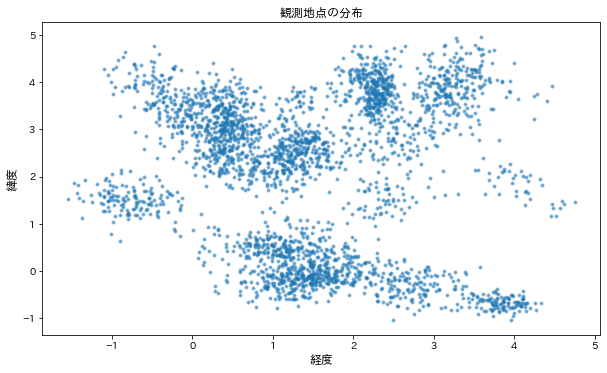

In [18]:
##観測地点間の距離分布を生成
#場所集合のトピックを生成
s = 30
prob = np.random.dirichlet(np.repeat(1.0, s), 1).reshape(-1)
point = np.dot(np.random.multinomial(1, prob, place), np.arange(s))
n = np.array([np.sum(point==j) for j in range(s)])

#観測地点の経緯度を生成
longitude = np.array([0, 5]); latitude = np.array([0, 5])
geo_spot0 = np.zeros((place, 2))
for j in range(s):
    index = np.array(np.where(point==j)[0], dtype="int")
    mu = np.append(np.random.uniform(longitude[0], longitude[1]), np.random.uniform(latitude[0], latitude[1]))
    Cov = np.diag(np.random.uniform(0.01, 0.15, 2))
    cor = np.random.uniform(-0.6, 0.6, 1) * np.prod(np.sqrt(np.diag(Cov)))
    Cov[0, 1] = cor; Cov[1, 0] = cor
    geo_spot0[index, ] = np.random.multivariate_normal(mu, Cov, n[j])
geo_spot = np.min(geo_spot0) + geo_spot0

#経緯度を可視化
fig = plt.figure(figsize=(10.0, 5.75))
plt.scatter(geo_spot[:, 0], geo_spot[:, 1], alpha=0.5, linewidths="2", s=4)
plt.title("観測地点の分布")
plt.xlabel("経度", fontsize=12.0)
plt.ylabel("緯度", fontsize=12.0)

Text(0, 0.5, '頻度')

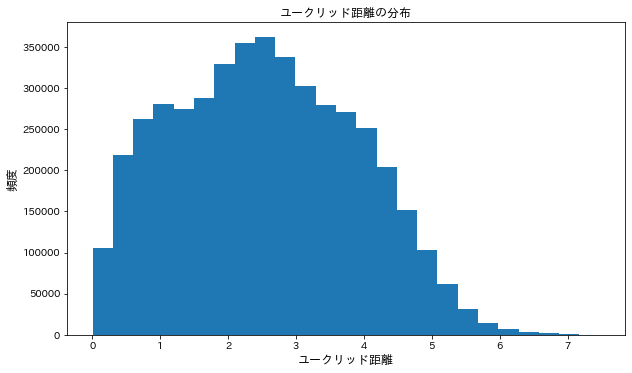

In [19]:
#場所間のユークリッド距離を定義
d = np.zeros((place, place))
for i in range(place):
    d[i, ] = np.sqrt(np.sum(np.power(geo_spot[np.repeat(i, place), ] - geo_spot, 2), axis=1))

#分布を可視化
fig = plt.figure(figsize=(10.0, 5.75))
plt.hist(d[np.triu(d, k=1)!=0.0], bins=25)
plt.title("ユークリッド距離の分布")
plt.xlabel("ユークリッド距離", fontsize=12.0)
plt.ylabel("頻度", fontsize=12.0)

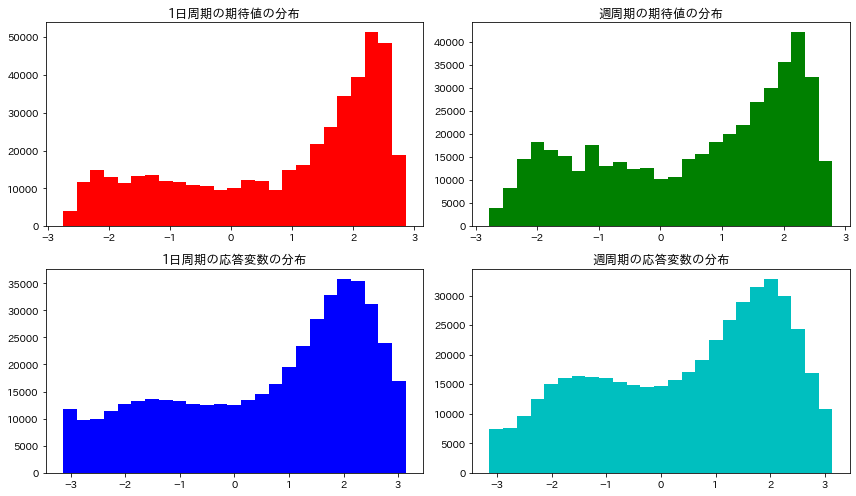

In [133]:
##応答変数の生成
#分散共分散行列を生成
I = np.diag(np.repeat(1.0, place))
phi1 = np.array([1.25]); phi2 = np.array([1.0])
tau1 = np.array([0.75]); tau2 = np.array([0.5])
gamma1 = np.array([0.7]); gamma2 = np.array([0.5])
delta1 = np.array([phi1, tau1, gamma1]).reshape(-1)
delta2 = np.array([phi2, tau2, gamma2]).reshape(-1)
Cov1 = tau1*I + gamma1*np.exp(-phi1 * d)
Cov2 = tau1*I + gamma2*np.exp(-phi2 * d)

#事前分布を定義
alpha1 = 0.0
alpha2 = 0.0
alpha_u1 = np.repeat(0.0, place)
alpha_u2 = np.repeat(0.0, place)
tau1 = 1.0
tau2 = 0.75
kappa1 = np.random.uniform(3.0, 7.5, 1)
kappa2 = np.random.uniform(3.0, 7.5, 1)

#モデルパラメータを生成
beta1 = np.array([0.75])
beta2 = np.array([0.85])
beta_u1 = np.append(np.random.normal(alpha1, tau1, category), 0.0)
beta_u2 = np.append(np.random.normal(alpha2, tau2, category), 0.0)
theta_u1 = np.random.multivariate_normal(alpha_u1, Cov1, 1).reshape(-1)
theta_u2 = np.random.multivariate_normal(alpha_u2, Cov2, 1).reshape(-1)

#フォンミーゼス分布から円周データを生成
mu1 = 2*np.arctan(beta1 + theta_u1[d_id] + np.dot(beta_u1[category_id, ], m_vec))
mu2 = 2*np.arctan(beta2 + theta_u2[d_id] + np.dot(beta_u2[category_id, ], m_vec))
y1 = np.random.vonmises(mu1, kappa1, N)
y2 = np.random.vonmises(mu2, kappa2, N)

#生成したデータを可視化
dt = [mu1, mu2, y1, y2]
fig_range = np.append(np.array([np.min(mu1), np.min(mu2), np.min(y1), np.min(y2)]), 
                      np.array([np.max(mu1), np.max(mu2), np.max(y1), np.max(y2)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["1日周期の期待値の分布", "週周期の期待値の分布", "1日周期の応答変数の分布", "週周期の応答変数の分布"]
fig = plt.figure(figsize=(12.0, 7.0))
for j in range(len(dt)):
    ax = fig.add_subplot(2, 2, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()